In [146]:
#IMPORT PACKAGES
import sys
import os
from rdflib import Graph
from pathlib import Path
import rdflib
import open3d as o3d
import numpy as np
import cv2
import ezdxf as cad
import pye57 
import time
import numpy
import ifcopenshell
# import shapely
from rdflib import RDF, RDFS, Graph, Literal, URIRef

In [147]:
%autoreload 2

In [148]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
# #GEOMAPI
parent_dir = os.path.dirname(Path(os.getcwd()))
sys.path.append(parent_dir)
from geomapi.nodes import *
import geomapi.utils as ut
import geomapi.utils.geometryutils as gmu
import geomapi.utils.imageutils as iu
import geomapi.utils.cadutils as cadu

import geomapi.tools as tl
# import geomapi.tools.alignmenttools as alt
import geomapi.tools.machinelearningtools as mlt
import geomapi.tools.progresstools as pgt
import geomapi.tools.validationtools as vlt

In [72]:
#DATA
from data_loader_road import DataLoaderRoad
dataLoaderRoad=DataLoaderRoad(Path.cwd()/"testfiles"  )

from data_loader_parking import DataLoaderParking
dataLoaderParking=DataLoaderParking(Path.cwd()/"testfiles"  )

Creating Road DataLoader:
    loaded d:\geomapi\tests\testfiles\graphs\road_session_graph.ttl
    loaded 64 bimNodes from ifc file
    loaded d:\geomapi\tests\testfiles\graphs\road_ifc_graph.ttl
    loaded PointCloud with 700000 points.
    loaded d:\geomapi\tests\testfiles\pcd\lidar.e57
    loaded d:\geomapi\tests\testfiles\graphs\pcd_graph.ttl
    loaded TriangleMesh with 26002 points and 49999 triangles.
    loaded d:\geomapi\tests\testfiles\graphs\mesh_graph.ttl
    loaded d:\geomapi\tests\testfiles\graphs\road_img_graph.ttl
    loaded d:\geomapi\tests\testfiles\img\101_0367_0007.JPG
    loaded d:\geomapi\tests\testfiles\img\101_0367_0055.JPG
DataLoader succesfully loaded in 6.486962080001831 seconds!
Creating Parking DataLoader:
    loaded d:\geomapi\tests\testfiles\graphs\parking_resource_graph.ttl
    loaded PointCloud with 556485 points.
    loaded d:\geomapi\tests\testfiles\pcd\lidar.e57
    loaded d:\geomapi\tests\testfiles\pcd\parking.e57
    loaded d:\geomapi\tests\testfile

In [73]:
# # imgNodes=[geomapi.imgNode(xmlPath=imageXmpPath1),imgNode(xmlPath=imageXmpPath1)]
# imgNode1=ImageNode(xmpPath=imageXmpPath1,getResource=True)
# imgNode2=ImageNode(xmpPath=imageXmpPath2,getResource=True)
# meshNode=MeshNode(path=meshPath,getResource=True)
# pcdNode=PointCloudNode(path=pcdPath,getResource=True)

In [74]:
# #get list of files
# files=[str(path / 'IMG' / 'DJI_0085.xmp'),str(path / 'IMG' / 'IMG_8834.xmp')]
# print(files)
# #select every fifth files
# imgNodes=[]
# for f in files:     
#     n=ImageNode(name=ut.get_filename(f),  #! this took quite long from remote drive                            
#                                 xmpPath=f,getResource=True)
#     del n.resource
#     if getattr(n,'imageWidth',None) is not None:
#     #delete resource
    

#         #set focallength and cartesianTransform
#         n.focalLength35mm=n.focalLength35mm/36*n.imageWidth #! multiple definitions possible    
#         rotation= n.cartesianTransform[0:3,0:3].T #! RC uses column-based rotaton matrix
#         translation=n.cartesianTransform[0:3,3]
#         n.cartesianTransform=gmu.get_cartesian_transform(rotation=rotation,translation=translation)
        
#         imgNodes.append(n)
    
# number=len(imgNodes)
# imgNodes=[n for n in imgNodes if all(n.cartesianTransform[0:3,3] !=0)]
# joinedImages=gmu.join_geometries([gmu.generate_visual_cone_from_image(n.cartesianTransform, height =1).paint_uniform_color([1,0,0]) for n in imgNodes])
# print(f"{len(imgNodes)} / {number} Nodes created (remainder is not properly localised)!")

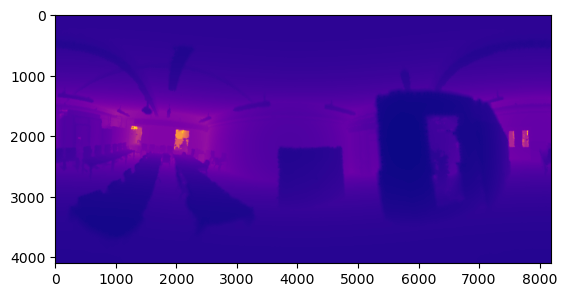

array([[2165., 2165., 2165., ..., 2165., 2165., 2165.],
       [2165., 2165., 2165., ..., 2165., 2165., 2165.],
       [2165., 2165., 2165., ..., 2165., 2165., 2165.],
       ...,
       [1864., 1864., 1864., ..., 1864., 1864., 1864.],
       [1864., 1864., 1864., ..., 1864., 1864., 1864.],
       [1864., 1864., 1864., ..., 1864., 1864., 1864.]])

In [151]:
path=r'D:\geomapi\tests\testfiles\img\00000-pano_depth.PNG'
vlt.decode_depthmap(path,show=True)

In [133]:
nodes=tl.graph_path_to_nodes(path=dataLoaderRoad.ifcGraphPath,getResource=True)


[Open3D WARNING] Unable to load file d:/geomapi/tests/testfiles/graphs/BT1_Bodembedekking_WSV10.obj with ASSIMP
[Open3D WARNING] Unable to load file d:/geomapi/tests/testfiles/graphs/BT1_Bodembedekking_WSV10.obj with ASSIMP
[Open3D WARNING] Unable to load file d:/geomapi/tests/testfiles/graphs/BT1_Bodembedekking_WSV10.obj with ASSIMP
[Open3D WARNING] Unable to load file d:/geomapi/tests/testfiles/graphs/BT1_Bodembedekking_WSV10.obj with ASSIMP
[Open3D WARNING] Unable to load file d:/geomapi/tests/testfiles/graphs/BT1_Grens_Circulatiezone_Zwakke_Weggebruiker_WCZ.obj with ASSIMP
[Open3D WARNING] Unable to load file d:/geomapi/tests/testfiles/graphs/BT1_Grens_Circulatiezone_Zwakke_Weggebruiker_WCZ.obj with ASSIMP
[Open3D WARNING] Unable to load file d:/geomapi/tests/testfiles/graphs/BT1_Onderbouw_Fundering.obj with ASSIMP
[Open3D WARNING] Unable to load file d:/geomapi/tests/testfiles/graphs/BT1_Onderbouw_Fundering.obj with ASSIMP
[Open3D WARNING] Unable to load file d:/geomapi/tests/test

In [117]:
o3d.visualization.draw_geometries([gmu.join_geometries([n.resource for n in nodes]),pcdNode.resource])

TypeError: draw_geometries(): incompatible function arguments. The following argument types are supported:
    1. (geometry_list: List[open3d.cpu.pybind.geometry.Geometry], window_name: str = 'Open3D', width: int = 1920, height: int = 1080, left: int = 50, top: int = 50, point_show_normal: bool = False, mesh_show_wireframe: bool = False, mesh_show_back_face: bool = False) -> None
    2. (geometry_list: List[open3d.cpu.pybind.geometry.Geometry], window_name: str = 'Open3D', width: int = 1920, height: int = 1080, left: int = 50, top: int = 50, point_show_normal: bool = False, mesh_show_wireframe: bool = False, mesh_show_back_face: bool = False, lookat: numpy.ndarray[numpy.float64[3, 1]], up: numpy.ndarray[numpy.float64[3, 1]], front: numpy.ndarray[numpy.float64[3, 1]], zoom: float) -> None

Invoked with: [[], PointCloud with 700000 points.]

In [7]:
ut.cartesianTransform_to_literal(imageCartesianTransform1)

'[[-8.13902571e-02]\n [ 6.83059476e-01]\n [-7.25813597e-01]\n [ 5.18276221e+01]\n [ 9.96648497e-01]\n [ 4.97790854e-02]\n [-6.49139139e-02]\n [ 6.10007435e+01]\n [-8.20972697e-03]\n [-7.28664391e-01]\n [-6.84821733e-01]\n [ 1.50408221e+01]\n [ 0.00000000e+00]\n [ 0.00000000e+00]\n [ 0.00000000e+00]\n [ 1.00000000e+00]]'

In [10]:
assert '-8.1390571e-02' in ut.cartesianTransform_to_literal(imageCartesianTransform1)

AssertionError: 